# Understand why the cost of HybridSIPP is much better than other algs

In [2]:
import sys
sys.path.append('../../')
from time import time
import numpy as np
from matplotlib import pyplot as plt

from panav.viz import draw_hybrid


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from panav.util import count_interger_var

from panav.SAMP.solvers import Tube_Planning
class Vanilla_Tube_Planning(Tube_Planning):
    def __init__(self, env, start, goal, vmax=1, bloating_r=0.5, d=2, t0=0, K_max=10, T_end_constraints=None, ignore_finished_agents=False, goal_reach_eps=None) -> None:
        super().__init__(env, start, goal, vmax, bloating_r, d, t0, K_max, T_end_constraints, ignore_finished_agents, goal_reach_eps)
         
        self.K =  self.K_max

    def plan(self,obstacle_trajectories=[],lazy=False):
        return self.plan_core(obstacle_trajectories)
    
    def count_int_constraints(self,obstacle_trajectories=[]):
        _,_,_,prob = self.plan_core(obstacle_trajectories,solve_inplace = False)
        return count_interger_var(prob)

In [4]:
from panav.sequential import sequential_HybridSIPP, sequential_planning
from functools import partial


bloating_r = 0.5
vmax = 1.0

TIMEOUT = 200

Ks = np.arange(2,11,2)

# Specify the Algorithms
algs = {  
        'HybridSIPP':lambda HG: sequential_HybridSIPP(HG,Kmax = 5,Delta=3.0,return_on_failure=False)
        }

seq_plan = lambda HG,k: sequential_planning(partial(Vanilla_Tube_Planning,K_max = k),HG.env,vmax,bloating_r,TIMEOUT=TIMEOUT)
for k in Ks:
    algs[f"K={k}"]= partial(seq_plan,k=k)


/Users/tianpengzhang/opt/miniconda3/envs/PA-NAV/lib/python3.11/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/tianpengzhang/opt/miniconda3/envs/PA-NAV/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


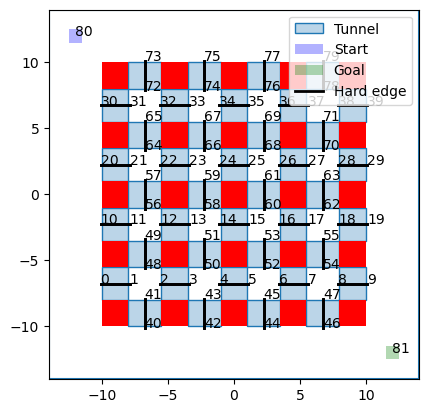

In [5]:
from panav.environment.env import WareHouse
from panav.hybrid import WareHouseHG

# Warehouse
n_agents = list(range(1,41,10))
limits = [(-14,14),(-14,14)]
bloating_r = 0.5


specs = dict(limits = limits, 
                shelf_region_x_limit=[-10,10], 
                shelf_region_y_limit=[-10,10],
                obs_x_margin = 5.0 * bloating_r,
                obs_y_margin = 5.0 * bloating_r,
                n_col = 5, n_row = 5 , 

                corner_padding_x=5,corner_padding_y=5,
                bloating_r = bloating_r,
                tunnel_endpoint_buffer = 0.05)

env = WareHouse(**specs,N_agent=1)
env.starts[0] = np.array([-12,12])
env.goals[0] = np.array([12,-12])
env.calc_start_goal_regions()
HG = WareHouseHG(env,agent_radius=bloating_r)

draw_hybrid(HG)


In [6]:
algs

{'HybridSIPP': <function __main__.<lambda>(HG)>,
 'K=2': functools.partial(<function <lambda> at 0x1108fd800>, k=2),
 'K=4': functools.partial(<function <lambda> at 0x1108fd800>, k=4),
 'K=6': functools.partial(<function <lambda> at 0x1108fd800>, k=6),
 'K=8': functools.partial(<function <lambda> at 0x1108fd800>, k=8),
 'K=10': functools.partial(<function <lambda> at 0x1108fd800>, k=10)}

In [7]:
from time import time
plans_out = {}
runtimes = {}
for name,alg in algs.items():
    t0 = time()
    plan = alg(HG)
    runtimes[name] = time()-t0
    plans_out[name] = plan

0
Km= 0
Solve time 0.025916099548339844
Planning for agent 0/1
self.K 2 K_max 2 In init
self.K 2
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-15
Planning for agent 0/1
self.K 4 K_max 4 In init
self.K 4
Planning for agent 0/1
self.K 6 K_max 6 In init
self.K 6
Planning for agent 0/1
self.K 8 K_max 8 In init
self.K 8
Planning for agent 0/1
self.K 10 K_max 10 In init
self.K 10


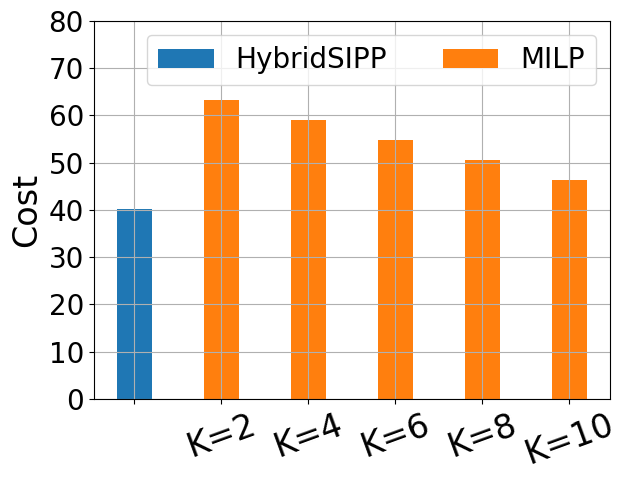

In [8]:
X = np.arange(len(algs))*2
Y = [plan[0][0][-1] for plan in plans_out.values()]
plt.bar(X[0],Y[0],label='HybridSIPP')
plt.bar(X[1:],Y[1:],label='MILP')
plt.grid('on')
plt.yticks(fontsize=20)
plt.xticks(X,['']+[f'K={K}' for K in Ks],rotation=20,fontsize=24)
plt.legend(prop={'size':20},ncol=2)
plt.ylabel("Cost",fontsize=24)
plt.tight_layout()
plt.ylim((0,80))
plt.savefig('./simFigures/PathQuality/cost.pdf')
plt.show()


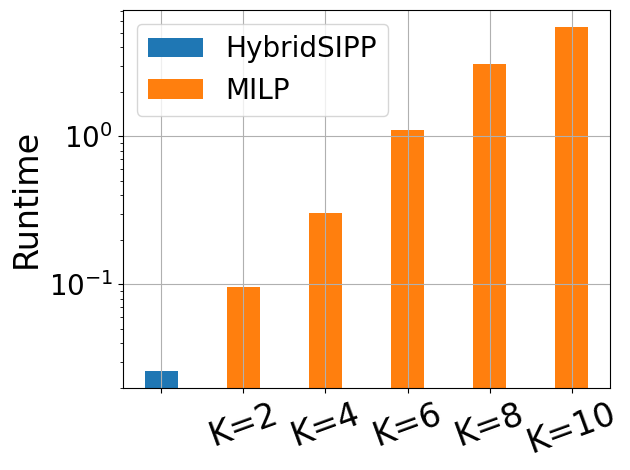

In [9]:
X = np.arange(len(algs))*2
Y = list(runtimes.values())
plt.bar(X[0],Y[0],label='HybridSIPP')
plt.bar(X[1:],Y[1:],label='MILP')
plt.grid('on')
plt.yticks(fontsize=20)
plt.xticks(X,['']+[f'K={K}' for K in Ks],rotation=20,fontsize=24)
plt.legend(prop={'size':20})
plt.ylabel("Runtime",fontsize=24)
plt.yscale('log')
plt.tight_layout()
plt.savefig('./simFigures/PathQuality/runtime.pdf')
plt.show()

/Users/tianpengzhang/opt/miniconda3/envs/PA-NAV/lib/python3.11/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(
/Users/tianpengzhang/opt/miniconda3/envs/PA-NAV/lib/python3.11/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child1), but could not find a label for it.
  warnings.warn(
/Users/tianpengzhang/opt/miniconda3/envs/PA-NAV/lib/python3.11/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child2), but could not find a label for it.
  warnings.warn(
/Users/tianpengzhang/opt/miniconda3/envs/PA-NAV/lib/python3.11/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child3), but could not find a label for it.
  warnings.warn(


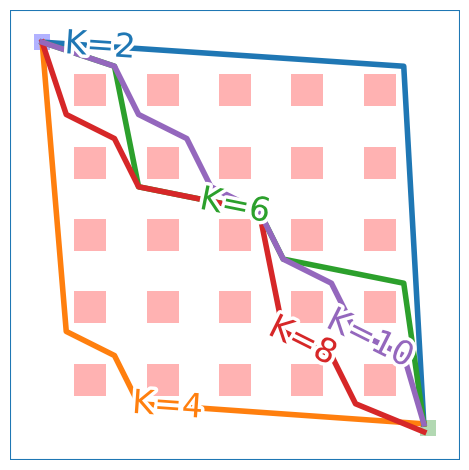

In [10]:
from panav.viz import draw_env
from labellines import labelLines
draw_env(HG.env)

for name,val in plans_out.items():
    if name!='HybridSIPP':
        xs = val[0][1]
        plt.plot(xs[0,:],xs[1,:],label = name,lw=4)

labelLines(plt.gca().get_lines(),fontsize=24)
plt.axis('off')
plt.tight_layout()
l = plt.gca().get_legend()
l.remove()
plt.savefig('./simFigures/PathQuality/MILP_paths.pdf')
plt.show()


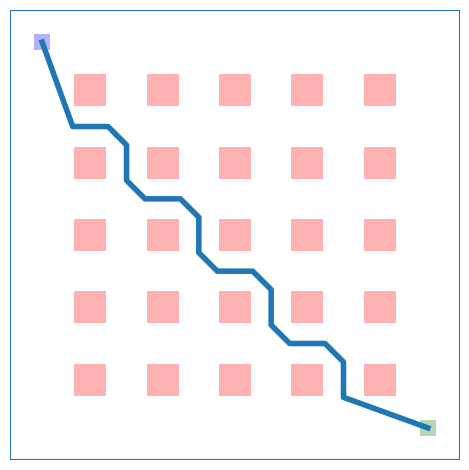

In [11]:
from panav.viz import draw_env
from labellines import labelLines
draw_env(HG.env,no_legend=True)

for name,val in plans_out.items():
    if name=='HybridSIPP':
        xs = val[0][1]
        plt.plot(xs[0,:],xs[1,:],lw=4)

plt.axis('off')
plt.tight_layout()

plt.savefig('./simFigures/PathQuality/SIPP_path.pdf')
plt.show()


In [13]:
from matplotlib import pyplot as plt
from panav.viz import animation
from IPython.display import HTML, display
from matplotlib import rcParams
from panav.util import interpolate_positions

plans = plans_out['HybridSIPP']
exec_tau = 1.0

rcParams['animation.embed_limit'] = 2**128
dt = exec_tau 
agents = range(len(plans))
pos_to_ani = []

for cp in plans:
    _,xs = interpolate_positions(*cp,dt)
    pos_to_ani.append(xs)
    
anim = animation(HG.env, pos_to_ani, bloating_r, dt = dt)
display(HTML(anim.to_jshtml()))
plt.close() 